## Compare population specific transcript identities 
## between Tau metric and discovery metric

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
# min_samples = 2
# min_cpm = 0.1
# tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
min_cpm = 0.1
tau_df = pd.read_csv(f'241031_med_{min_cpm}_tau.tsv', sep='\t')

In [4]:
# plot tau value vs. population specific transcripts
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [5]:
tau_df.head()

,tid,tau
0,transcript_6675,0.324285
1,transcript_6676,0.355661
2,transcript_6684,0.228488
3,transcript_11363,0.342149
4,transcript_11364,0.307322


In [6]:
tau_df = tau_df.merge(mt_df[['isoform', 'pop_spec_t']], 
                      how='left', 
                      left_on='tid',
                      right_on='isoform')

In [7]:
tau_df.head()

,tid,tau,isoform,pop_spec_t
0,transcript_6675,0.324285,transcript_6675,False
1,transcript_6676,0.355661,transcript_6676,False
2,transcript_6684,0.228488,transcript_6684,False
3,transcript_11363,0.342149,transcript_11363,False
4,transcript_11364,0.307322,transcript_11364,False


In [8]:
tau_df['pop_spec_t'] = tau_df['pop_spec_t'].fillna('Undefined')

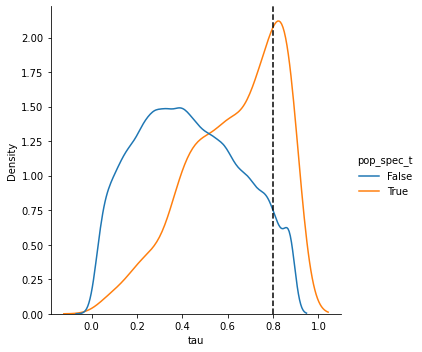

In [9]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')

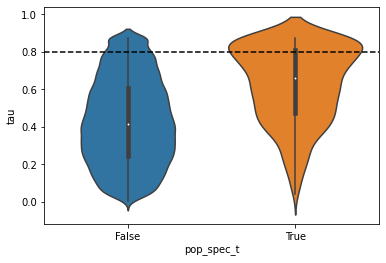

In [10]:
ax = sns.violinplot(tau_df, y='tau', x='pop_spec_t')
plt.axhline(0.8, color='k', linestyle='--')

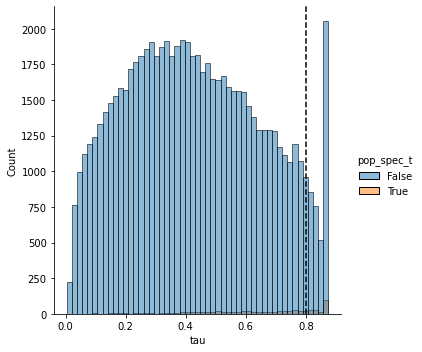

In [11]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t')
plt.axvline(0.8, color='k', linestyle='--')

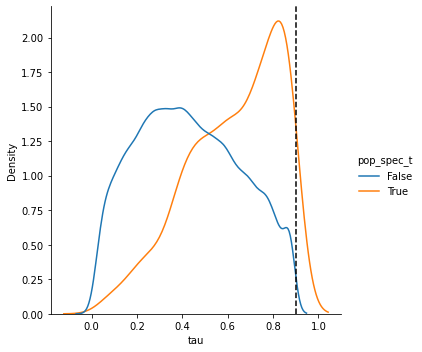

In [12]:
temp = tau_df.loc[tau_df.pop_spec_t!='Undefined']
ax = sns.displot(temp, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.9, color='k', linestyle='--')

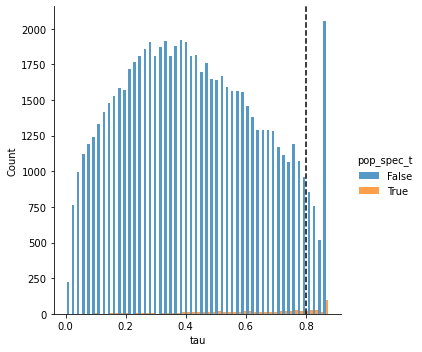

In [13]:
ax = sns.displot(temp, x='tau', hue='pop_spec_t',
                 multiple='dodge', edgecolor=None)
plt.axvline(0.8, color='k', linestyle='--')

In [14]:
tau_df['tau_pop_spec_t'] = tau_df.tau>=0.8

In [15]:
tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique()

tid
pop_spec_t tau_pop_spec_t       
False      False           69124
           True             4559
True       False             486
           True              174

In [22]:
tau_df.loc[tau_df.tau_pop_spec_t, 'tau'].min()

0.8000151384562713

In [23]:
tau_df.to_csv('241031_tau_0.1_min_cpm_0.8_min_tau.tsv', sep='\t')

In [17]:
## Fischer's exact test
temp = tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique().reset_index()

temp.head()
temp = temp.pivot(index='tau_pop_spec_t',
                  values = 'tid',
                  columns = 'pop_spec_t')
temp = temp.values
temp
# Perform Fisher's Exact Test
odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')


# # get the CI of these results
# result = st.contingency.odds_ratio(temp, kind='conditional')
# odds_ratio_value = result.statistic
# confidence_interval = result.confidence_interval(confidence_level=0.95)


print("Odds Ratio:", odds_ratio)
print("P-value:", p_value)
# print("Conditional Odds Ratio:", odds_ratio_value)
# print("95% Confidence Interval:", confidence_interval)

Odds Ratio: 5.428405081252928
P-value: 1.2746331047482791e-59


In [20]:
temp

array([[69124,   486],
       [ 4559,   174]])

In [18]:
import scipy
scipy.__version__

'1.7.3'

In [19]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau'] # these should be higher
y = tau_df[tau_df['pop_spec_t'] == False]['tau'] # these should be lower

# alt hypothesis is that y > x or x < y

# ‘two-sided’: one of the distributions (underlying x or y) is stochastically greater than the other.

# ‘less’:  x < y.

# ‘greater’:  x > y.

# do the test
stat, p_value = st.ranksums(x, y,
                            alternative='greater')


print(f'Wilcoxon Rank Sum Test Statistic: {stat}')
print(f'P-value: {p_value}')


Wilcoxon Rank Sum Test Statistic: 21.160442795929615
P-value: 1.1056810686678372e-99


In [91]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau']
y = tau_df[tau_df['pop_spec_t'] == False]['tau']

# Perform the Mann-Whitney U test
stat, p_value = st.mannwhitneyu(x, y,
                                alternative='greater')

print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U Test Statistic: 89250251.5
P-value: 1.1126968164177252e-43


In [99]:
# Split the data based on "pop_spec_t"
x = tau_df[tau_df['pop_spec_t'] == True]['tau']
y = tau_df[tau_df['pop_spec_t'] == False]['tau']

# Perform the Mann-Whitney U test
stat, p_value = st.mannwhitneyu(x, y,
                                alternative='two-sided')

print(f'Mann-Whitney U Test Statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U Test Statistic: 89250251.5
P-value: 2.2253936328354503e-43


In [ ]:
# can I get which population is the specific one?